In [1]:
# for colab
# !pip install -qq rasterio timm
# !pip install -Uqq fastbook

In [2]:
from fastai.vision.all import *
from fastai.torch_core import TensorMask, TensorImage
import rasterio as rio
import timm
import torch
import fastai
from rasterio.enums import Resampling
import torch.multiprocessing
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# import SaveModelCallback from fastai
from fastai.callback.tracker import SaveModelCallback
from fastai.vision.all import Normalize
from fastai.data.block import DataBlock
from fastai.data.block import TransformBlock
from fastai.vision.core import TensorImage, TensorMask
from fastai.vision.augment import RandTransform
from fastai.vision.core import default_device
import random
from functools import partial
import numpy as np

In [3]:
model_version = "1.31"  # Assigns string value to model_version

In [4]:
# download training data is needed

# import gdown
# import zipfile

# training_data_zip_path = Path.cwd() / "training data/training data.zip"
# training_data_zip_path.parent.mkdir(parents=True, exist_ok=True)
# url = "https://drive.google.com/uc?id=1ohuFbG7zV73ZUTIM3ybAlOk87n-nppov"
# gdown.download(url, str(training_data_zip_path), quiet=False)

# with zipfile.ZipFile(training_data_zip_path, "r") as zip_ref:
#     zip_ref.extractall(path=training_data_zip_path.parent)

In [5]:
# for colab
# path = training_data_zip_path.parent

# for local
path = Path("/media/nick/SNEAKERNET/training data")

label_path = path / "labels_2_3_4_8_V3"

images_path = path / "images_2_3_4_8_V3"
print(label_path.exists(), images_path.exists())
print(label_path)

True True
/media/nick/SNEAKERNET/training data/labels_2_3_4_8_V3


In [6]:
print(torch.__version__)
print(fastai.__version__)
print(default_device())

2.0.0.post200
2.7.12
cuda:0


In [7]:
# enabling this will speed up training but can result in NAN loss
fp_16 = True

In [8]:
# list all models available in timm
# timm.list_models()

In [9]:
model_type = "regnety_002"

In [10]:
model_name = (
    f"{model_type}_v{model_version}_model"  # Assigns string value to model_name
)
temp_file_name = model_name + "_temp"
model_name, temp_file_name

('regnety_002_v1.31_model', 'regnety_002_v1.31_model_temp')

In [11]:
b, g, r, nir = 1, 2, 3, 4
# how many time steps to use max is 6
time_steps = 6
# pick the bands you want to use
only_use = [g, nir]
bands_per_timestep = len(only_use)

In [12]:
limited_band_read_list = []
for i in range(time_steps):
    for band in only_use:
        limited_band_read_list.append(i * 4 + band)
limited_band_read_list

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

In [13]:
def label_func(label_path, file_path):
    label_path = label_path / file_path.name

    return label_path

In [14]:
# func to get img list to use excluding the bad images
def get_image_files_custom(source, p=False):
    return list(source.glob("[!.]*.tif"))

In [15]:
f_names = list(get_image_files_custom(images_path))
len(f_names)

12839

In [16]:
f_names[0]

Path('/media/nick/SNEAKERNET/training data/images_2_3_4_8_V3/853_OSM_80.tif')

In [17]:
validation_paths = []
for img in f_names:
    if "Validation" in img.name:
        validation_paths.append(img)

len(validation_paths)

400

In [18]:
def is_valid_file(x, validation_paths):
    return x in validation_paths

In [19]:
class Switcheroo(RandTransform):
    "Randomly switch the order of the time steps, keeping the band order the same"

    split_idx, order = 0, 2

    def __init__(self, p=1, bands_per_timestep=2, time_steps=3):
        super().__init__(p=p)
        self.bands_per_timestep = bands_per_timestep
        self.time_steps = time_steps

    def encodes(self, x: (TensorImage)):
        new_time_step_order = torch.randperm(self.time_steps)
        new_order = [
            (i * self.bands_per_timestep) + j
            for i in new_time_step_order
            for j in range(self.bands_per_timestep)
        ]
        return x[:, new_order]

In [20]:
class BatchRot90(RandTransform):
    "Rotate image and mask by 0, 90, 180, or 270 degrees"

    split_idx, order = 0, 2

    def __init__(self, p=1):
        super().__init__(p=p)
        self.rots = 0

    def before_call(self, b, split_idx):
        if random.random() < self.p:
            self.rot = random.choice([0, 1, 2, 3])
        else:
            self.rot = 0

    def encodes(self, x: (TensorImage, TensorMask)):
        return x.rot90(self.rot, [-2, -1])

In [21]:
def open_mask(img_path, img_size):
    with rio.open(img_path) as src:
        raw_bands = src.read(
            1, out_shape=(img_size, img_size), resampling=Resampling.nearest
        )
    return TensorMask(torch.from_numpy(raw_bands))

In [22]:
image_cache = {}

In [23]:
def open_img(img_path, img_size):
    if img_path in image_cache:
        tensor_img = image_cache[img_path]
        if tensor_img.shape[-1] == img_size:
            return tensor_img
    with rio.open(img_path) as src:
        raw_bands = src.read(limited_band_read_list, out_shape=(img_size, img_size))

    tensor_img = TensorImage(torch.from_numpy(raw_bands.astype("float16")))
    if fp_16:
        tensor_img = tensor_img.half()

    tensor_img = tensor_img.cuda()

    image_cache[img_path] = tensor_img
    return tensor_img

In [24]:
open_img(f_names[0], 256).shape

torch.Size([12, 256, 256])

In [25]:
# all_means = []
# all_stds = []
# for i in tqdm(f_names):
#     image_tensor = open_img(i, 256) / 32767
#     all_means.append(image_tensor.mean((1, 2)).tolist())
#     all_stds.append(image_tensor.std((1, 2)).tolist())
# all_stds = np.array(all_stds).mean((0))
# all_means = np.array(all_means).mean((0))
# # break

In [26]:
all_means = np.array(
    [
        0.09320524,
        0.09936677,
        0.09359581,
        0.09989304,
        0.09392498,
        0.0994415,
        0.09318926,
        0.09834657,
        0.09105494,
        0.09607462,
        0.09178863,
        0.09679132,
    ]
)

In [27]:
all_stds = np.array(
    [
        0.02172433,
        0.02760383,
        0.02274428,
        0.02833729,
        0.02223172,
        0.0276719,
        0.02222958,
        0.02731097,
        0.02183141,
        0.02698776,
        0.02132447,
        0.02619315,
    ]
)

In [28]:
# build datablock
def build_dblock(img_size):
    open_img_partial = partial(open_img, img_size=img_size)
    open_mask_partial = partial(open_mask, img_size=img_size)
    lable_func_partial = partial(label_func, label_path)

    label_block = TransformBlock(open_mask_partial)
    dblock = DataBlock(
        blocks=(TransformBlock(open_img_partial), label_block),
        get_items=get_image_files_custom,
        get_y=lable_func_partial,
        splitter=FuncSplitter(lambda x: is_valid_file(x, validation_paths)),
        batch_tfms=[
            IntToFloatTensor(32767, 1),
            *aug_transforms(
                flip_vert=True,
                max_rotate=0,
                max_zoom=0.2,
                max_lighting=0.2,
                max_warp=0,
                p_affine=0,
                p_lighting=0.2,
                size=img_size,
            ),
            BatchRot90(),
            # Switcheroo(bands_per_timestep=bands_per_timestep, time_steps=time_steps),
            Normalize.from_stats(mean=all_means, std=all_stds),
        ],
    )
    return dblock

In [29]:
dl = build_dblock(256).dataloaders(images_path, bs=16, num_workers=0)

In [30]:
ob = dl.one_batch()

In [31]:
ob[0].shape

torch.Size([16, 12, 256, 256])

In [32]:
timm_model = partial(
    timm.create_model,
    model_type,
    pretrained=True,
    in_chans=dl.one_batch()[0].shape[1],
)

In [33]:
loss_func = MSELossFlat()
n_out = 1

In [34]:
learner = unet_learner(
    dl, timm_model, pretrained=True, loss_func=loss_func, n_out=n_out
)
if fp_16:
    print("Converting to FP16")
    learner.to_fp16()

Converting to FP16


In [35]:
cbs = [
    SaveModelCallback(monitor="valid_loss", fname=model_name, with_opt=True),
    ShowGraphCallback(),
]

epoch,train_loss,valid_loss,time
0,8.786747,6.652798,29:40
1,5.915830,5.611108,05:32
2,4.462501,4.421339,05:35
3,5.081703,3.732517,05:35
4,5.100562,3.602183,05:36
5,4.934813,3.803901,05:35
6,4.564613,3.251159,05:38
7,4.052091,3.113942,05:35
8,3.666131,3.319707,05:37
9,nan,4.187673,05:38


Better model found at epoch 0 with valid_loss value: 6.652797698974609.


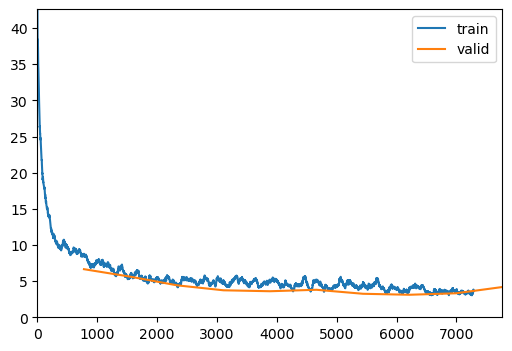

Better model found at epoch 1 with valid_loss value: 5.61110782623291.
Better model found at epoch 2 with valid_loss value: 4.4213385581970215.
Better model found at epoch 3 with valid_loss value: 3.7325170040130615.
Better model found at epoch 4 with valid_loss value: 3.6021833419799805.
Better model found at epoch 6 with valid_loss value: 3.2511589527130127.
Better model found at epoch 7 with valid_loss value: 3.1139416694641113.


epoch,train_loss,valid_loss,time
0,2.203688,2.467252,05:43
1,2.253708,2.419158,05:47
2,2.561017,2.469260,05:45
3,1.941755,2.466624,05:40
4,2.376737,2.340764,05:48
5,2.255659,2.366972,05:42
6,2.123576,2.697381,05:44
7,3.051296,3.188153,05:45
8,2.099087,2.312596,05:47
9,1.676972,2.380519,05:42


Better model found at epoch 0 with valid_loss value: 2.467251777648926.


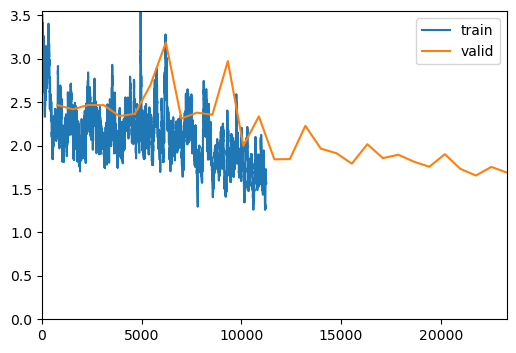

Better model found at epoch 1 with valid_loss value: 2.4191582202911377.
Better model found at epoch 4 with valid_loss value: 2.340764045715332.
Better model found at epoch 8 with valid_loss value: 2.312596321105957.
Better model found at epoch 12 with valid_loss value: 1.9979231357574463.
Better model found at epoch 14 with valid_loss value: 1.8429298400878906.
Better model found at epoch 19 with valid_loss value: 1.7928575277328491.
Better model found at epoch 24 with valid_loss value: 1.7570312023162842.
Better model found at epoch 26 with valid_loss value: 1.7329678535461426.
Better model found at epoch 27 with valid_loss value: 1.656388282775879.


In [36]:
learner.fine_tune(
    freeze_epochs=10,
    epochs=30,
    cbs=cbs,
)

In [37]:
# reload best model
learner.load(model_name)

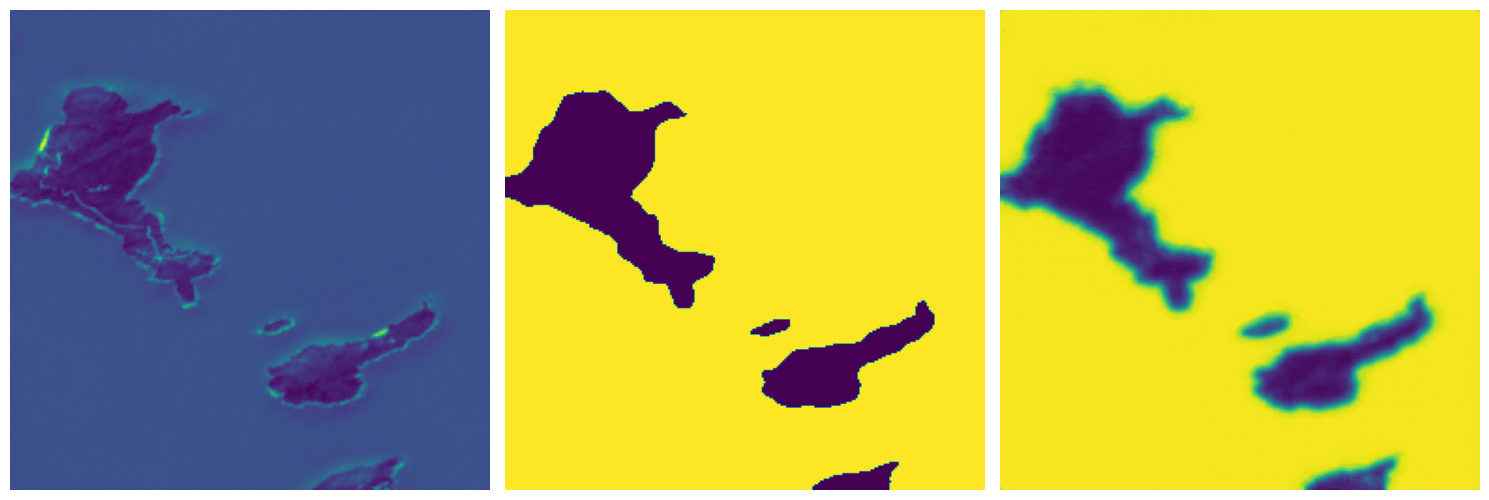

In [38]:
img_numb = 0
p = learner.predict(validation_paths[img_numb], with_input=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 row, 3 columns
axes[0].imshow(p[0].numpy()[2])
axes[0].axis("off")
axes[1].imshow(p[1].numpy()[0] > 0)
axes[1].axis("off")
axes[2].imshow(p[1].numpy()[0])
axes[2].axis("off")
plt.tight_layout()

In [39]:
pickle.dump(
    learner.model.to("cpu"), open(Path.cwd() / f"models/{model_name}.pkl", "wb")
)

In [40]:
f"{model_name}.pkl"

'regnety_002_v1.31_model.pkl'